## Intro to Monte Carlo methods for option pricing

In [408]:
# Clear all variables (habit from MATLAB)
%reset -f
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import os
import time
from datetime import datetime
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")



## Essential python/numpy functions and techniques

***Essential Numpy Moves***

**E1:**

Create a 1 000 000‑sample vector of i.i.d. 𝒩(0, 1) numbers. 2. Re‑create it as float32 without an explicit loop.

In [5]:
x64 = np.random.standard_normal((1000000,1)) # produce 1 million "independent and identically distributed" (iid) random numbers.
print(x64[1:5])
x32 = x64.astype(np.float32) # convert to 32 bit float

[[-0.29274736]
 [ 0.74768368]
 [ 0.83232078]
 [ 0.06265928]]



**E2:**

Turn a 100 × 100 matrix into a 10 × 10 × 100 “batch cube” where each frontal slice is 10 × 10

In [6]:
X = np.random.standard_normal((100,100)) # produce 100 x 100 iid random numbers.
Y = X.reshape(10,10,100)

**E3**

Compute all pairwise dot‑products of 100 random 3‑D vectors with and without a for‑loop.

In [9]:
N = 100
V = np.zeros((N,N), int)

# first with a for loop
v1 = np.random.randint(1,10,(N,3))
start_time_1 = time.time()
for i in range(N):
    for j in range(N):
        V[i,j] = np.dot(v1[i],v1[j].T)
end_time_1 = time.time()


# now with einsum
start_time_2 = time.time()
d2 = np.einsum('ik,jk->ij', v1, v1)
end_time_2 = time.time()


execution_time_1 = end_time_1 - start_time_1
execution_time_2 = end_time_2 - start_time_2
ex_diff = execution_time_1 - execution_time_2
print(f"Execution time difference in for loop vs einsum: {ex_diff} seconds")

Execution time difference in for loop vs einsum: 0.039880990982055664 seconds


**E3**

Compute the product of 

1) Two matrices
2) Matrix with a vector
3) Batched matrix multiplication
4) Using broadcastring compute the product of a batch of matrices with a single matrix

In [11]:
A = np.array([[1, 2], [3, 4]])
B = np.array([[5, 6], [7, 8]])
v = np.array([3, 6])

C = np.einsum('ij,jk->ik', A, B)  # Matrix multiplication using einsum
D = np.matmul(A, B)  # Matrix multiplication using matmul
print(C==D) # Check if the results are the same

X1 = np.einsum('ij,j -> i', A, v) 
X2 = np.matmul(A, v)
X1-X2 # Check if the results are the same

D = np.array([[[1, 2], [3, 4]], [[5, 6], [7, 8]]])
E = np.array([[[9, 8], [7, 6]], [[5, 4], [3, 2]]])

X3 = np.matmul(D, E)
print(X3)

F = np.array([[[1, 2], [3, 4]], [[5, 6], [7, 8]]])
G = np.array([[1, 2], [3, 4]])

result = np.matmul(F, G)
print(result)


[[ True  True]
 [ True  True]]
[[[23 20]
  [55 48]]

 [[43 32]
  [59 44]]]
[[[ 7 10]
  [15 22]]

 [[23 34]
  [31 46]]]


**E3**

Generate 100 paths of geometric Brownian motion, each with 1000 timesteps, return a vector of pathwise means in one line.

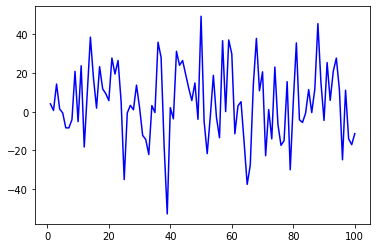

In [ ]:
y = np.random.standard_normal((100, 1000)) # produce 100 x 1000 iid random numbers 
cum_sum = np.cumsum(y, axis=1) # cumulative sum along the second axis
mean_cum_sum = np.mean(cum_sum, axis=1) # mean of the cumulative sum along the second axis

# ------------------------------------------------------------------------------------------
# In  one line
y = np.random.default_rng(22).standard_normal((100,1000)).cumsum(1).mean(1)
x = range(1,101)
plt.plot(x, y, label='Mean of Cumulative Sum', color='blue')

## Black–Scholes partial-differential equation 



Analytically solve the BS equations for a European option.

---

***The Black–Scholes Model in PDE Form***

***Core assumptions***
1. **Underlying dynamics** – The (discounted) stock price follows *geometric Brownian motion*  
   $$dS_t = (r-q)\,S_t\,dt + \sigma S_t\,dW_t ,$$
   with constant drift $(r-q)$ and volatility $(\sigma).$
2. **No arbitrage & frictionless markets** – You can trade continuously, borrow/lend at the risk-free rate $r$, and short without costs.  
3. **European payoff** – The option’s payoff depends only on $S_T$ at a fixed expiry $T$.  

***The pricing PDE***
Form a self-financing portfolio $\Pi = V - \Delta S$ that is *locally risk-free* by choosing $\Delta = \frac{\partial V}{\partial S}$.  
Applying Itô’s lemma to $V(t,S_t)$ and equating the portfolio’s drift to the risk-free rate yields the **Black–Scholes PDE** 

$$
\boxed{\;
\frac{\partial V}{\partial t} + \tfrac12\sigma^{2}S^{2}\frac{\partial^{2}V}{\partial S^{2}}
      + (r-q)S\frac{\partial V}{\partial S} \;-\; rV \;=\; 0\;}
$$

with terminal condition $V(T,S) = \text{payoff}(S)$.  

---

***3 Closed-Form Solution for a European Call / Put***
From wikipedia/book

Solving the PDE with payoff $C(T,S)=\max(S-K,0)$ (call) or $P(T,S)=\max(K-S,0)$ (put) gives  

$$
\begin{aligned}
C &= S e^{-qT} N(d_1) - K e^{-rT} N(d_2),\\[4pt]
P &= K e^{-rT} N(-d_2) - S e^{-qT} N(-d_1),
\end{aligned}
$$
where  
$$
d_{1,2} = \frac{\ln(S/K) + (r-q \pm \tfrac12\sigma^2)T}{\sigma\sqrt{T}},\qquad
N(\cdot)=\text{standard normal CDF}.
$$
and 
$$
N'(x)=\frac{1}{\sqrt{2\pi}}e^{-x^{2}/2}, \text{ is the standard normal PDF}
$$
Let us plot the CDF and PDF for the normal distribution different values of $\mu$ and $\sigma$ below to gain some intuition

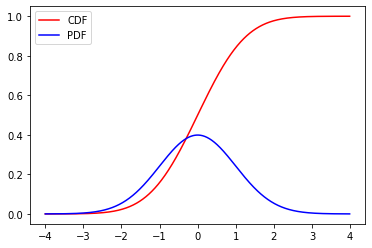

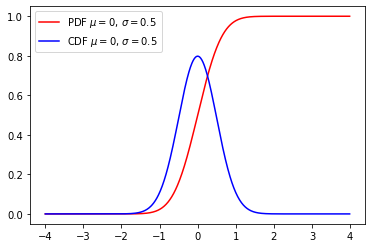

In [ ]:
y = np.random.standard_normal((100, 1))
x = np.arange(-4, 4, 0.01)
plt.figure()
plt.plot(x,norm.cdf(x), label='CDF', color='red') # CDF of standard normal distribution with mean=0 and std=1
plt.plot(x, norm.pdf(x), label='PDF', color='blue')
plt.legend()

plt.figure()
plt.plot(x,norm.cdf(x,0,0.5), label='PDF $\mu=0$, $\sigma=0.5$',color='red') # PDF of normal distribution with mean=0 and std=0.1
plt.plot(x,norm.pdf(x,0,0.5), label='CDF $\mu=0$, $\sigma=0.5$',color='blue') # CDF of normal distribution with mean=0 and std=0.1
plt.legend()

**Greeks: Formulas, Units, and Intuition**

| Greek | Definition | Closed-form (call) | Units | Practical meaning |
|-------|-------------|--------------------|-------|-------------------|
| **Delta** $\displaystyle \Delta = \frac{\partial V}{\partial S}$ | Sensitivity to an *infinitesimal* change in spot price | $\displaystyle e^{-qT}N(d_1)$ | dimensionless | **Hedge ratio** – hold $\Delta$ shares per option to neutralise first-order price moves. |
| **Gamma** $\displaystyle \Gamma = \frac{\partial^{2} V}{\partial S^{2}}$ | Curvature of price vs. spot | $\displaystyle \frac{e^{-qT}N'(d_1)}{S\sigma\sqrt{T}}$ | 1/price | Measures how *Delta* changes as $S$ moves; large near-ATM, short-dated.  Drives *convexity* benefits and risk of delta-hedging error. |
| **Vega** $\displaystyle \nu = \frac{\partial V}{\partial \sigma}$ | Volatility sensitivity | $\displaystyle S e^{-qT} N'(d_1)\sqrt{T}$ | price per vol-point | How much the option’s value moves per 1 % absolute change in σ.  Central for volatility trading. |
| **Theta** $\displaystyle \Theta = -\frac{\partial V}{\partial T}$ | Time-decay (negative for long calls/puts) | $\displaystyle -\frac{S e^{-qT} N'(d_1)\sigma}{2\sqrt{T}} - r K e^{-rT} N(d_2) + q S e^{-qT} N(d_1)$ | price / year | P/L from *letting the clock tick*.  Think of it as the “rent you pay” to be long optionality. |
| **Rho** $\displaystyle \rho = \frac{\partial V}{\partial r}$ | Risk-free rate sensitivity | $\displaystyle K T e^{-rT} N(d_2)$ | price / rate-pt | Gain/loss if the term structure shifts; opposite sign for puts. |
| **Psi** $\displaystyle \psi = \frac{\partial V}{\partial q}$ (“dividend-rho”) | Dividend-yield sensitivity | $-S T e^{-qT} N(d_1)$ | price / yield-pt | Relevant for equity indexes with known dividend yield. |
---

***Greeks in Risk Management & Trading***

| Greek | Typical hedging instrument | Why it matters day-to-day |
|-------|---------------------------|---------------------------|
| Delta | Underlying shares / futures | Neutralise directional exposure. |
| Gamma | Additional options (usually shorter-dated) | Manage the *rate* at which delta changes; high gamma means you must rebalance frequently. |
| Vega  | Options at different strikes/expiries, variance swaps | Express pure volatility views (“vol trading”). |
| Theta | Carry budget / financing | Determines expected daily bleed; options desks quote “theta-dollars” per night. |
| Rho   | Bond futures / swaps | Small for equities but important in FX and rates options. |

In [ ]:
# Second iteration of the code that used the "sign" for the option type (in the first iteration I had two different calculations for call and put options)
def analytic_greek(S, K, T, sigma, r=0.0, q=0.0,  option_type: str = "call"):
    F = S*np.exp(-q * T)
    B = K*np.exp(-r * T)
    sqrtT  = np.sqrt(T)
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (d1 - sigma * np.sqrt(T))

    if option_type == "call":
        sign = 1
    else:
        sign = -1

    N1 = norm.cdf(sign*d1)
    N2 = norm.cdf(sign*d2)
    N1_prime = norm.pdf(d1)
    price = sign*(F*N1 - B*N2)
    delta = sign*np.exp(-q * T) * N1
    gamma = np.exp(-q * T) * N1_prime / (S * sigma * sqrtT)
    vega  = S * np.exp(-q * T) * N1_prime * sqrtT
    theta = sign*(-0.5 * S * np.exp(-q * T) * N1_prime * sigma / sqrtT +
            +q * F * N1 - r * B * N2)
    rho   = sign*np.exp(-r * T) * K * T * N2

    return price, d1, d2, delta, gamma, theta, vega, rho

In [6]:
def check_analytic_greek():
    # Test the analytic_greek function for known case
    X = analytic_greek(100, 95, 0.75, 0.24, 0.03, 0.01,"call")
    return np.isclose(X,[11.534305993009554, 0.4228768097884608, 0.21503071288019557, 0.6588474956611785, 0.017421264426114427, -5.988989966253025, 31.358275967005966, 40.76283267983122])
check_analytic_greek()

array([ True,  True,  True,  True,  True,  True,  True,  True])

## Monte carlo of European and Asian options



**European options** can be exercised on their experiation date. We simulate the pricepath by iteratively updating the price by $S_{i}=S_{i-1}e^{(r-q-\frac{1}{2}\sigma^2)\text{d}t+\sigma \sqrt{\text{d}t}Z_i}$, with Z being Monte Carlo generated numbers.

For Asian (european) options the final price is given as an average over some pre-disclosed time interval. If there is only one timestep, this will be equal to the European option.

American options can be exercised at any point. For the american option there is no closed form solution

In [367]:
def mc_euro(S0, K, T, sigma, r=0.0, q=0.0, option_type: str = "call", npaths=10000, nsteps=1000):
    dt = T / nsteps
    S = np.zeros((npaths, nsteps + 1))
    S[:, 0] = S0
    for i in range(1, nsteps + 1):
        Z = np.random.standard_normal(npaths)  # standard normal random variables
        S[:,i] = S[:, i - 1]*np.exp((r - q - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)
    if option_type == "call":
        price = np.exp(-r * T) * np.mean(np.maximum(S[:, -1] - K, 0))
        err = np.exp(-r * T) * np.std(np.maximum(S[:, -1] - K, 0)) / np.sqrt(npaths)
    elif option_type == "put":
        price = np.exp(-r * T) * np.mean(np.maximum(K - S[:, -1], 0))
        err = np.exp(-r * T) * np.std(np.maximum(K - S[:, -1], 0)) / np.sqrt(npaths)
    return price, err

***Checks***

Let us check the accuracy compared to the analytic solution and how it changes as N changes:

([<matplotlib.lines.Line2D at 0x26c02631d08>],
 [1.8632217301042777,
  0.43289368845146203,
  0.17649723536118866,
  0.09586271621154818,
  0])

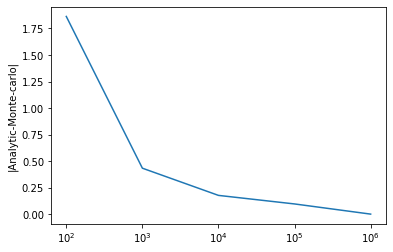

In [17]:
def check_mc(S,K,T,sigma,r,q):
    Y = analytic_greek(S,K,T,sigma,r,q,"call")
    dif = [0,0,0,0,0]
    for i in range(2, 6):
        X = mc_euro(S,K,T,sigma,r,q, "call" , 10**(i), 1000)
        dif[i-2] = np.abs(X[0] - Y[0])
    plt.figure()
    out = plt.plot(['$10^2$','$10^3$','$10^4$','$10^5$','$10^6$'], dif)
    plt.ylabel('|Analytic-Monte-carlo|')
    return out, dif
check_mc(100, 105, 0.75, 0.24, 0.03, 0.01)

The plot above should go to 0 as $N\to\infty$

***Asian options***

Lets now do a MC of asian options. This is similar to the European option, but in the end we take the mean over the values of S during the path, to set the price

In [358]:
def mc_asian(S0,K,T,sigma,r,q,option_type: str = "call", npaths=10000, nsteps=1000):
    dt = T/nsteps
    S = np.zeros((npaths, nsteps + 1))
    S[:, 0] = S0
    for i in range(1, nsteps + 1):
        Z = np.random.standard_normal(npaths)  # standard normal random variables
        S[:,i] = S[:, i - 1]*np.exp((r - q - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)
    S_mean = np.mean(S[:, 1:], axis=1)  # mean of the paths
    if option_type == "call":
        price = np.exp(-r * T) * np.mean(np.maximum(S_mean - K, 0))
        err = np.exp(-r * T) * np.std(np.maximum(S_mean - K, 0)) / np.sqrt(npaths)
    elif option_type == "put":
        price = np.exp(-r * T) * np.mean(np.maximum(K - S_mean, 0))
        err = np.exp(-r * T) * np.std(np.maximum(K - S_mean, 0)) / np.sqrt(npaths)
    return price

In [364]:
mc_asian(100, 105, 0.75, 0.24, 0.03, 0.01,"call", npaths=10000, nsteps=1000)

3.0744791001245564

Let us test that this is equal to the European options when taking nsteps = 1 (i.e. ending the Monte Carlo paths immediatly, so the average is the same as the final value)

In [374]:

def test_regression_to_euro(S,K,T,sigma,r,q,option_type: str = "call", npaths=10000):
    nsteps=1
    X = mc_asian(S, K, T, sigma, r ,q ,"call", npaths, nsteps)
    Y = mc_euro(S, K, T, sigma, r, q, "call", npaths, nsteps)
    Z = analytic_greek(S, K, T, sigma, r, q, "call")
    return np.isclose(X,Y[0],10**(-2)),np.isclose(X,Z[0],10**(-2)), X, Y[0], Z[0]
    
out = test_regression_to_euro(100, 105, 0.75, 0.24, 0.03, 0.01,"call", npaths=1000000)
print("Test if Asian mc is close to Euro mc: ", out[0])
print("Test if Asian mc is close to Euro analytic: ", out[1])
print("Asian mc price: ", out[2])
print("Euro mc price: ", out[3])
print("Euro analytic price: ", out[4])

Test if Asian mc is close to Euro mc:  True
Test if Asian mc is close to Euro analytic:  True
Asian mc price:  6.747275842146164
Euro mc price:  6.767607887475131
Euro analytic price:  6.760519238235446


## American options

For the american options things get more complicated since we can exercise early. First let us do the "simplest" thing and just do Monte Carlo and just simulate the paths and find the average price that givs the highest pay-off. This will give an "upper bound" on the price.

In [403]:
def mc_american_simple(S0, K, T, sigma, r=0.0, q=0.0, option_type: str = "put", npaths = 10000, nsteps = 100):
    # First we simulate the paths, using the same method as in mc_euro.
    dt    = T / nsteps
    drift = (r - q - 0.5 * sigma**2) * dt
    diff  = sigma * np.sqrt(dt)

    S = np.empty((npaths, nsteps + 1))
    S[:, 0] = S0
    for t in range(1, nsteps + 1):
        Z = np.random.standard_normal(npaths)
        S[:, t] = S[:, t-1] * np.exp(drift + diff * Z)

    if option_type == "call":
        price = np.maximum(S - K, 0.0)
    elif option_type == "put":
        price = np.maximum(K - S, 0.0)

    disc_vec = np.exp(-r * dt * np.arange(nsteps + 1))
    discounted = price * disc_vec 

    payoff_path = discounted.max(axis=1) 
    price  = payoff_path.mean()
    stderr = payoff_path.std(ddof=1) / np.sqrt(npaths)
    return price, stderr, 

mc_american_simple(100, 105, 0.75, 0.24, 0.03, 0.01,"call", npaths=10000, nsteps=100)

(13.027759698805028, 0.14803816216485094)

**LS monte carlo for american options**

Let us now consider two different algorithms for pricing options. The first one is the Schwartz-Longstaff algorithm (https://people.math.ethz.ch/%7Ehjfurrer/teaching/LongstaffSchwartzAmericanOptionsLeastSquareMonteCarlo.pdf)

Here we do the normal monte carlo path, but we determine a stopping condition from a linear regression that we propagate backwards at each step in the path

In [ ]:
def mc_american(S0, K, T, sigma, r=0.0, q=0.0, option_type: str = "put", npaths = 10000, nsteps = 100):
    # Simulate the paths, using the same method as in mc_euro.
    dt    = T / nsteps
    drift = (r - q - 0.5 * sigma**2) * dt
    diff  = sigma * np.sqrt(dt)

    S = np.empty((npaths, nsteps + 1))
    S[:, 0] = S0
    for t in range(1, nsteps + 1):
        Z = np.random.standard_normal(npaths)
        S[:, t] = S[:, t-1] * np.exp(drift + diff * Z)

    # Define a payoff function that we can call at each step
    if option_type.lower() == "call":
        def intrinsic(s):
            return np.maximum(s - K, 0.0)
    elif option_type.lower() == "put":
        def intrinsic(s):
            return np.maximum(K - s, 0.0)

    # Longstaff–Schwartz backward loop

    disc = np.exp(-r * dt)                # One‑step discount factor exp(-r * dt). multiplied once per backward step.
    cash = intrinsic(S[:, -1])            # terminal pay‑offs
    
    # Now we go backwards in time, starting from t = nsteps - 1 and go through the last column of S[:, t] to the first column S[:, 0]
    first_ex = np.full(npaths, nsteps, dtype=int) # defined here to save the first exercise time for each path
    for t in range(nsteps - 1, 0, -1):
        cash *= disc                      # roll every path one step back

        itm = intrinsic(S[:, t]) > 0      # only in‑the‑money paths
        if not itm.any():
            continue

        X = S[itm, t]           # Define X and Y for the regression, from longstaff-schwartz paper   
        Y = cash[itm]                     

        # Perform regression using least squared fit on X and Y with basis: [1, S, S²]
        A = np.column_stack((np.ones_like(X),  X, X**2))
        beta, *_ = np.linalg.lstsq(A, Y)
        continuation = A @ beta # continuation value by evaluating on the regression coefficients

        # exercise decision
        exercise = intrinsic(X) > continuation
        idx      = np.where(itm)[0]
        cash[idx[exercise]] = intrinsic(X[exercise])
        first_ex[idx[exercise]] = np.minimum(first_ex[idx[exercise]], t)

    price  = disc * cash.mean()
    stderr = disc * cash.std(ddof=1) / np.sqrt(npaths)
    return price, stderr, first_ex, S, dt

**Check**

Let us check that the new mc alogrithm is less than the previous one (the simple algorithm we wrote is an "upper bound")

In [407]:
A1 = mc_american_simple(100, 105, 0.75, 0.24, 0.03, 0.01,"call", npaths=10000, nsteps=100)
A2 = mc_american(100, 105, 0.75, 0.24, 0.03, 0.01,"call", npaths=10000, nsteps=100)[0]
print("American mc price: ", A2, "is less than the upper bound", A1[0])

American mc price:  6.70395686749739 is less than the upper bound 12.601415867271072


***Binomial tree***

Now let's do this using a binomial tree